In [18]:
from qiskit import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
import numpy as np
import math
simulator = BasicAer.get_backend('qasm_simulator')

# Quantum Generative Adversarial Networks (qGANs)

Preparing discrete probability distributions using qGANs. 

$$$$

$$|\phi\rangle = \sum_{x=0}\sqrt{p_x}|x\rangle$$

$$$$

Some applications:

 * Generate artifficial data sets 

 * Encoding data for QML models efficiently
 
 * Finance (option pricing)

### 1. Target distribution

<BarContainer object of 8 artists>

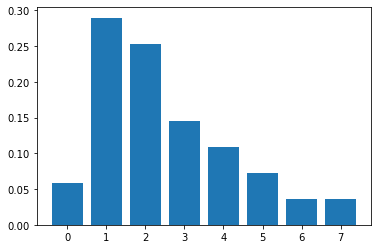

In [19]:
prob_distr = [8, 40, 35, 20, 15, 10, 5, 5]
#normalization 
prob_distr = [k/sum(prob_distr) for k in prob_distr]
plt.bar(range(len(prob_distr)),prob_distr)

### 2. Creating a hardware-efficient ansatz

$$U_{\vec{\theta}}|\psi_{in}\rangle = |\psi_{\vec{\theta}}\rangle$$

In [20]:
def ansatz(param, num_layers):    
    num_q = 3
    qc = QuantumCircuit(num_q, num_q)    
    for j in range(num_layers):        
        for i in range(num_q):
            qc.ry(param[i + j*num_q], i)        
        if j < num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,0)
    qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

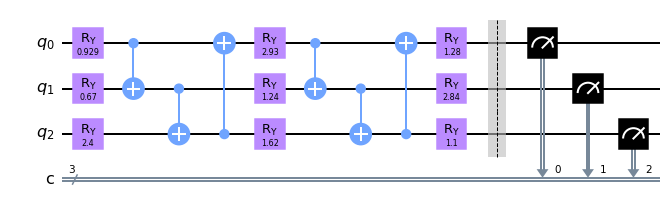

In [21]:
ansatz(param = np.random.uniform(0, np.pi, 9), num_layers=3).draw('mpl',fold=-1)

### 3. Loss functions used

$$$$

Mean squared error (MSE)

$$ \mathcal{L}_\theta = \sum_{i=0}(\hat{p}_i^\theta - y_i)^2 $$

Empirical Risk

$$ \mathcal{L}_\theta = \sum_{i=0} | \hat{p}_i^\theta - y_i | $$

Cross-entropy

$$ \mathcal{L}_\theta = \sum_{i=0} y_i\log{p_i^\theta} $$


In [22]:
num_layers = 5
def loss_function(params):
    
    num_shots=1024
    circ = ansatz(param=params, num_layers=num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = ['000','001','010','011','100','101','110','111']
    
    for i in strings:
        if i not in counts:
            counts[i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    
    """
    cross_entropy = 0
    for i in range(len(p)):
        if p[i]>0:
            cross_entropy -= prob_distr[i]*math.log2(p[i])
    
    return cross_entropy

    """
    return sum([(p[i] - prob_distr[i])**2 for i in range(len(prob_distr))])
    #return sum([abs(p[i] - prob_distr[i]) for i in range(len(prob_distr))])
    #return sum([ prob_distr[i]*math.log2(p[i]) for i in range(len(prob_distr))])
    

In [23]:
num_params = 3*num_layers
loss_function(params = np.zeros(num_params))

1.0764545263600085

### 4. Training the quantum circuit

In [24]:
from qiskit.algorithms.optimizers import COBYLA,SLSQP,SPSA
optimizer = COBYLA(250)
ret = optimizer.optimize(num_vars=num_params, objective_function=loss_function, initial_point=np.ones(num_params))

In [25]:
num_shots = 1024

trained_circ = ansatz(param=ret[0], num_layers=num_layers)
counts = execute(trained_circ, backend=simulator, shots=num_shots).result().get_counts(trained_circ)
strings = ['000','001','010','011','100','101','110','111']

for k in strings:
    if k not in counts:
        counts[k]=0

counts = [counts[i]/1024 for i in strings]


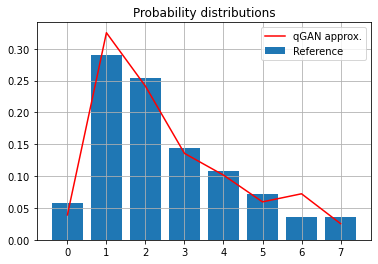

In [28]:
plt.plot(range(len(counts)),counts, color='r')
plt.bar(range(len(prob_distr)), prob_distr)
plt.legend(["qGAN approx.", "Reference"])
plt.title("Probability distributions")
plt.grid()